/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.6974 - loss: 0.7590 - val_accuracy: 0.9550 - val_loss: 0.1697
Epoch 2/100
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9127 - loss: 0.2201 - val_accuracy: 0.9649 - val_loss: 0.1225
Epoch 3/100
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9389 - loss: 0.1557 - val_accuracy: 0.9804 - val_loss: 0.0929
Epoch 4/100
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9503 - loss: 0.1253 - val_accuracy: 0.9772 - val_loss: 0.0872
Epoch 5/100
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9573 - loss: 0.1100 - val_accuracy: 0.9776 - val_loss: 0.0789
Epoch 6/100
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9626 - loss: 0.0999 - val_accuracy: 0.9808 - val_loss: 0.0702
Epoch 7/100
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9649 - loss: 0.0890 - val_accuracy: 0.9801 - val_loss: 0.0676
Epoch 8/100
1353/1353 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9690 - loss: 0

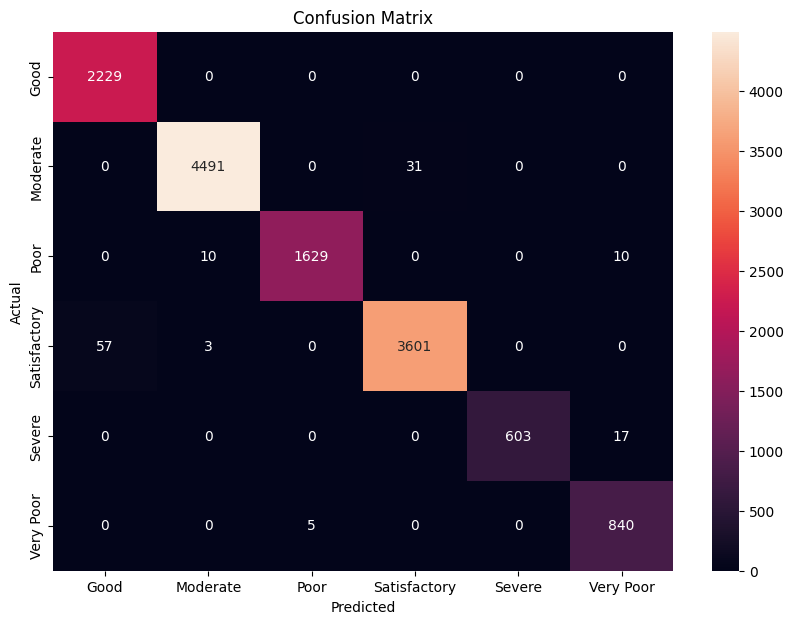

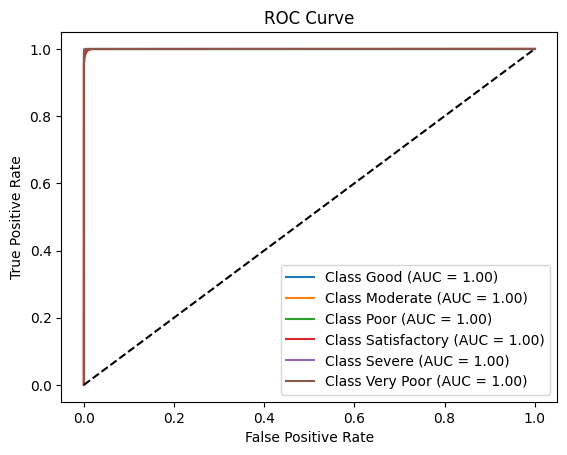

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# Load city-level and station-level datasets
city_data = pd.read_csv('/kaggle/input/air-quality-data-in-india/city_day.csv')
station_data = pd.read_csv('/kaggle/input/air-quality-data-in-india/station_day.csv')

# Select relevant columns (common features in both datasets)
common_columns = ['Date', 'PM2.5', 'PM10', 'NO2', 'SO2', 'CO', 'O3']

# Filter datasets to only include these columns
city_data = city_data[common_columns]
station_data = station_data[common_columns]

# Concatenate the two datasets
combined_data = pd.concat([city_data, station_data])

# Handle missing values by dropping rows with NaNs
combined_data = combined_data.dropna()

# Convert 'Date' to datetime format and drop the column (not needed for model training)
combined_data['Date'] = pd.to_datetime(combined_data['Date'])
combined_data = combined_data.drop('Date', axis=1)

# Label creation: Assuming AQI categories are predefined based on pollutant levels
def calculate_aqi_category(row):
    # Example logic: Customize this function based on your AQI breakpoints
    pm25, pm10, no2, so2, co, o3 = row['PM2.5'], row['PM10'], row['NO2'], row['SO2'], row['CO'], row['O3']
    if pm25 <= 50 and pm10 <= 50:
        return 'Good'
    elif pm25 <= 100 and pm10 <= 100:
        return 'Satisfactory'
    elif pm25 <= 200 and pm10 <= 200:
        return 'Moderate'
    elif pm25 <= 300 and pm10 <= 300:
        return 'Poor'
    elif pm25 <= 400 and pm10 <= 400:
        return 'Very Poor'
    else:
        return 'Severe'

# Apply the function to create labels
combined_data['AQI_Category'] = combined_data.apply(calculate_aqi_category, axis=1)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(combined_data['AQI_Category'])

# Select feature columns
X = combined_data.drop('AQI_Category', axis=1)

# Normalize the feature values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Save the model
model.save('best_combined_air_quality_model.h5')
